# Object detection and segmentation with the Gemini API


**References:**
* [Conversational image segmentation with Gemini 2.5](https://developers.googleblog.com/en/conversational-image-segmentation-gemini-2-5/)
* [Use Gemini 2.5 for Zero-Shot Object Detection & Segmentation](https://blog.roboflow.com/gemini-2-5-object-detection-segmentation/)

---

## Setup

### Software Development Kit (SDK)

Installing and initializing the Google Generative AI SDK, a collection of tools and libraries that allow developers to interact with Google's Gemini models.  
This setup enables performing tasks such as text generation, image analysis, and segmentation.

In [1]:
# Install
#!pip install google-genai supervision

# Initialize
from google import genai
from google.genai import types

### Application Programming Interface (API) key and SDK client

The API key is loaded from an environment file (.env) to keep credentials secure.  
The client object authenticates requests and enables communication with Gemini models.

In [2]:
# Packages
import os
from dotenv import load_dotenv

# Load API key from environment file
load_dotenv("gemini_api_key.env")
client = genai.Client(api_key = os.getenv("GOOGLE_API_KEY"))

### Model

Spatial understanding works best with the **Gemini 2.0 Flash** model.  
It performs even better with **Gemini 2.5 models** (like `gemini-2.5-pro`), which are more capable "thinking models" — though slightly slower.  
Some advanced features, such as **image segmentation**, are only supported by **Gemini 2.5 models**.

**Available model options:**
- `gemini-2.0-flash`
- `gemini-2.5-flash-lite`
- `gemini-2.5-flash-lite-preview-09-2025`
- `gemini-2.5-flash`
- `gemini-2.5-flash-preview-09-2025`
- `gemini-2.5-pro`

**Temperature (creativity control):**
- Controls randomness/creativity of model output.  
- `0.0` → very deterministic, consistent output (best for precise tasks).  
- `0.5` → moderately creative (good balance for tasks like bounding boxes).  
- `1.0` → more creative, potentially less consistent output.

In [3]:
# Models
model_gemini_2_0 = "gemini-2.0-flash" 
model_gemini_2_5 = "gemini-2.5-flash"

# Temperature
temperature = 0.5

### Safety settings

This parameter specifies how the model should handle potentially harmful content.

In [4]:
safety_settings = [types.SafetySetting(category="HARM_CATEGORY_DANGEROUS_CONTENT",
                                       threshold="BLOCK_ONLY_HIGH",),]

### Other packages

Installing and importing additional packages required for image processing and data handling.  
- **Pillow (PIL)** is used to open and manipulate images.  
- **io** and **requests** modules help handle image data streams and HTTP requests.  
- **Supervision (sv)** is used for utilities like plotting bounding boxes and working with detection results.

In [5]:
# Packages

#!pip install Pillow
from PIL import Image

import io
from io import BytesIO

import requests

import supervision as sv

import json
import base64

### Error handling and retry parameters

In [6]:
# Packages
import time
from google.genai import errors as genai_errors

# Define retry configuration
max_retries = 10
wait_time = 1
current_retry = 0
response = None

## Object detection

### Dog 1.jpeg

In [25]:
# Load and Process Image

# Image path
image_path = "Example images/Dog 1.jpeg"

# Prompt
prompt = ("Detect the dog's tail. "
          "Output a JSON list of bounding boxes where each entry contains the 2D bounding box in the key \"box_2d\", "
          "and the text label in the key \"label\". Use descriptive labels.")

# Load and resize the image
image = Image.open(image_path)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

# Retry loop for API call
while current_retry < max_retries:
    try:
        print(f"Attempt {current_retry + 1}/{max_retries} to call the API...")
        
        # Original API request
        response = client.models.generate_content(model=model_gemini_2_0,
                                               contents=[resized_image, prompt],
                                               config=types.GenerateContentConfig(
                                                   temperature=temperature,
                                                   safety_settings=safety_settings,
                                                   thinking_config=types.ThinkingConfig(thinking_budget=0)))

        print("Success!")
        break

    except genai_errors.ClientError as e:
        # Handle client errors (e.g., 429)
        current_retry += 1
        if current_retry >= max_retries:
            print(f"Error: Reached max retries ({max_retries}). Aborting.")
            print(f"Last error: {e}")
            break
        
        print(f"429 Error. Waiting {wait_time}s before retry...")
        time.sleep(wait_time)
        wait_time *= 2 

    except Exception as e:
        # Catch unexpected errors
        print(f"Unexpected error: {e}")
        break

# Check if response is valid
if response:
    print(response.text)
else:
    print("Failed to get a response after all retries.")

Attempt 3/10 to call the API...
Success!
Here are the bounding box detections:
```json
[
  {"box_2d": [583, 336, 723, 395], "label": "tail"}
]
```


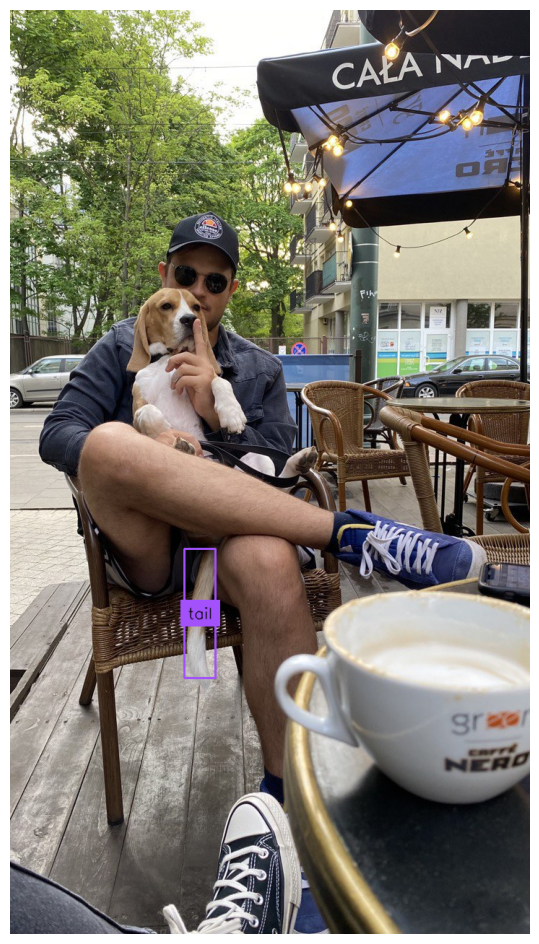

In [26]:
# Parse result and visualize

# Resolution of the image
resolution_wh = image.size

# Convert the model's output into Supervision Detections
detections = sv.Detections.from_vlm(vlm=sv.VLM.GOOGLE_GEMINI_2_5,
                                    result=response.text,
                                    resolution_wh=resolution_wh)

# Calculate optimal line thickness and text scale based on image resolution
thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

# Annotators for boxes and labels
box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(smart_position=True,
                                    text_color=sv.Color.BLACK,
                                    text_scale=text_scale,
                                    text_position=sv.Position.CENTER)

# Annotate the image with boxes and labels
annotated = image
for annotator in (box_annotator, label_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)

# Display the annotated image
sv.plot_image(annotated)

### Fruits.jpg

In [32]:
# Load and Process Image

# Image path
image_path = "Example images/Fruits.jpg"

# Prompt
prompt = ("Detect only chesse. "
          "Output a JSON list of bounding boxes where each entry contains the 2D bounding box in the key \"box_2d\", "
          "and the text label in the key \"label\". Use descriptive labels.")

# Load and resize the image
image = Image.open(image_path)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

# Retry loop for API call
while current_retry < max_retries:
    try:
        print(f"Attempt {current_retry + 1}/{max_retries} to call the API...")
        
        # Original API request
        response = client.models.generate_content(model=model_gemini_2_0,
                                               contents=[resized_image, prompt],
                                               config=types.GenerateContentConfig(
                                                   temperature=temperature,
                                                   safety_settings=safety_settings,
                                                   thinking_config=types.ThinkingConfig(thinking_budget=0)))

        print("Success!")
        break

    except genai_errors.ClientError as e:
        # Handle client errors (e.g., 429)
        current_retry += 1
        if current_retry >= max_retries:
            print(f"Error: Reached max retries ({max_retries}). Aborting.")
            print(f"Last error: {e}")
            break
        
        print(f"429 Error. Waiting {wait_time}s before retry...")
        time.sleep(wait_time)
        wait_time *= 2 

    except Exception as e:
        # Catch unexpected errors
        print(f"Unexpected error: {e}")
        break

# Check if response is valid
if response:
    print(response.text)
else:
    print("Failed to get a response after all retries.")

Attempt 3/10 to call the API...
429 Error. Waiting 4s before retry...
Attempt 4/10 to call the API...
Success!
```json
[
  {"box_2d": [441, 137, 697, 581], "label": "chesse"}
]
```


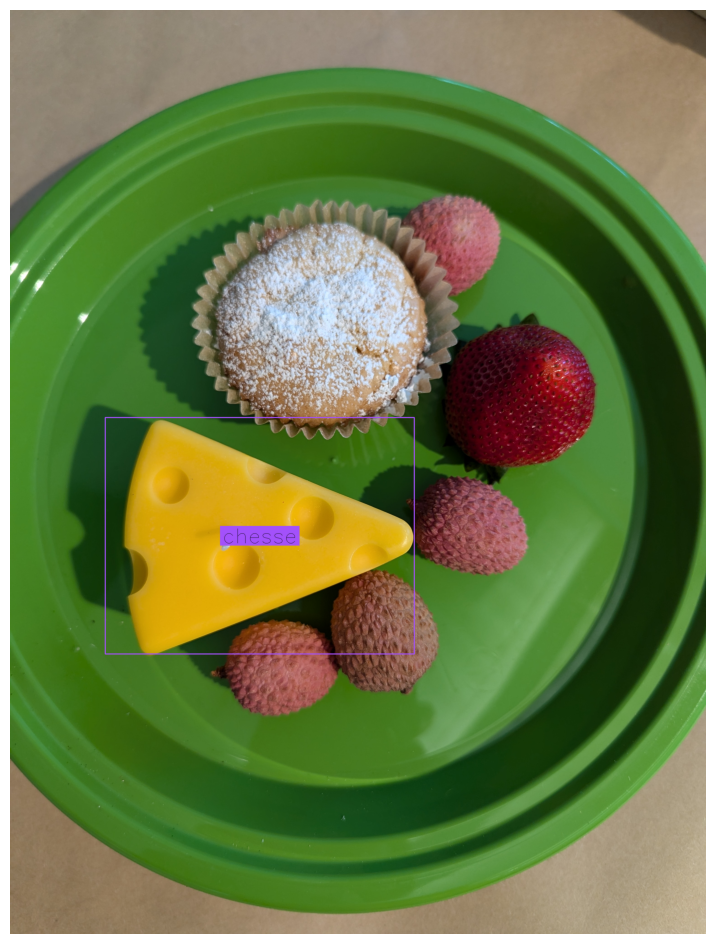

In [33]:
# Parse result and visualize

# Resolution of the image
resolution_wh = image.size

# Convert the model's output into Supervision Detections
detections = sv.Detections.from_vlm(vlm=sv.VLM.GOOGLE_GEMINI_2_5,
                                    result=response.text,
                                    resolution_wh=resolution_wh)

# Calculate optimal line thickness and text scale based on image resolution
thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

# Annotators for boxes and labels
box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(smart_position=True,
                                    text_color=sv.Color.BLACK,
                                    text_scale=text_scale,
                                    text_position=sv.Position.CENTER)

# Annotate the image with boxes and labels
annotated = image
for annotator in (box_annotator, label_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)

# Display the annotated image
sv.plot_image(annotated)

### Street segment 562002001.jpg

In [69]:
# Load and Process Image

# Image path
image_path = "Example images/562002001.jpg"

# Prompt
#prompt = ("Detect objects in the street scene. "
#          "Output a JSON list of bounding boxes where each entry contains the 2D bounding box in the key \"box_2d\", "
#          "and the text label in the key \"label\". Use descriptive labels.")

prompt = (
    "Detect all visible objects in this street scene, including vehicles, buildings, trees, grass, sidewalks, "
    "fences, gates, trash bins, street signs, lights, people, and any other relevant urban features. "
    "Output a JSON list of bounding boxes where each entry contains: "
    "1) the 2D bounding box in the key 'box_2d', "
    "2) the text label in the key 'label'. "
    "Use precise and descriptive labels, naming the type of object clearly. "
    "Include every detectable object, even if small or partially occluded."
)

# Load and resize the image
image = Image.open(image_path)
#width, height = image.size
#target_height = int(1024 * height / width)
#resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

# Retry loop for API call
while current_retry < max_retries:
    try:
        print(f"Attempt {current_retry + 1}/{max_retries} to call the API...")
        
        # Original API request
        response = client.models.generate_content(model=model_gemini_2_0,
                                               contents=[#resized_image, 
                                                         image, prompt],
                                               config=types.GenerateContentConfig(
                                                   temperature=temperature,
                                                   safety_settings=safety_settings,
                                                   thinking_config=types.ThinkingConfig(thinking_budget=0)))

        print("Success!")
        break

    except genai_errors.ClientError as e:
        # Handle client errors (e.g., 429)
        current_retry += 1
        if current_retry >= max_retries:
            print(f"Error: Reached max retries ({max_retries}). Aborting.")
            print(f"Last error: {e}")
            break
        
        print(f"429 Error. Waiting {wait_time}s before retry...")
        time.sleep(wait_time)
        wait_time *= 2 

    except Exception as e:
        # Catch unexpected errors
        print(f"Unexpected error: {e}")
        break

# Check if response is valid
if response:
    print(response.text)
else:
    print("Failed to get a response after all retries.")

Attempt 4/10 to call the API...
Success!
Here are the bounding box detections:
```json
[
  {"box_2d": [513, 921, 660, 950], "label": "vehicles"},
  {"box_2d": [643, 954, 1000, 1000], "label": "cars"},
  {"box_2d": [553, 367, 713, 392], "label": "van"},
  {"box_2d": [543, 563, 750, 638], "label": "fence"},
  {"box_2d": [0, 561, 543, 855], "label": "buildings"},
  {"box_2d": [740, 670, 933, 685], "label": "trash bin"},
  {"box_2d": [493, 702, 1000, 872], "label": "green structure"},
  {"box_2d": [0, 0, 876, 417], "label": "trees"},
  {"box_2d": [586, 392, 1000, 413], "label": "street"},
  {"box_2d": [536, 439, 870, 638], "label": "sidewalk"},
  {"box_2d": [746, 650, 936, 674], "label": "trash bin"},
  {"box_2d": [770, 431, 870, 458], "label": "street sign"},
  {"box_2d": [660, 0, 1000, 65], "label": "car"},
  {"box_2d": [506, 0, 913, 365], "label": "grass"}
]
```


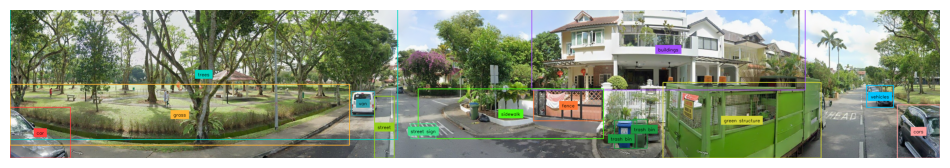

In [70]:
# Parse result and visualize

# Resolution of the image
resolution_wh = image.size

# Convert the model's output into Supervision Detections
detections = sv.Detections.from_vlm(vlm=sv.VLM.GOOGLE_GEMINI_2_5,
                                    result=response.text,
                                    resolution_wh=resolution_wh)

# Calculate optimal line thickness and text scale based on image resolution
thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

# Annotators for boxes and labels
box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(smart_position=True,
                                    text_color=sv.Color.BLACK,
                                    text_scale=text_scale,
                                    text_position=sv.Position.CENTER)

# Annotate the image with boxes and labels
annotated = image
for annotator in (box_annotator, label_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)

# Display the annotated image
sv.plot_image(annotated)
annotated.save("annotated_upscaled.jpg")

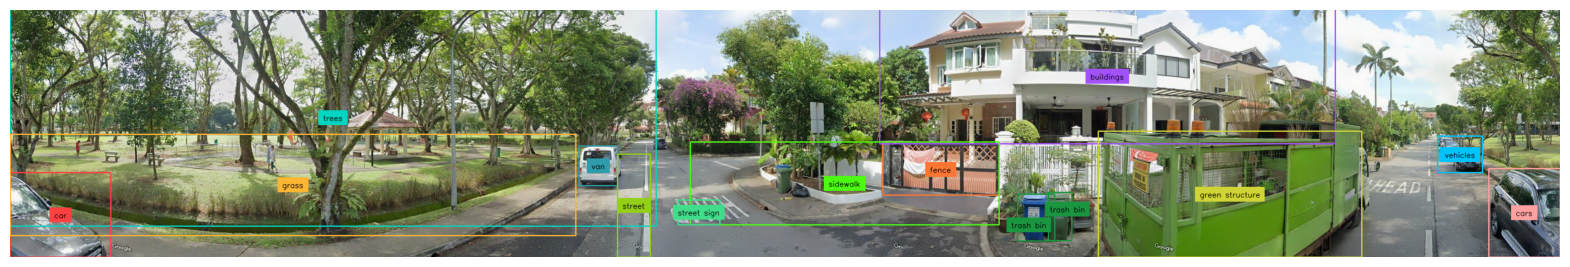

In [84]:
plt.figure(figsize=(20, 10))
plt.imshow(annotated)
plt.axis('off')
plt.show()

## Segmentation

### Dog 2.jpeg

Attempt 4/10 to call the API...
Success!
```json
[
  {"box_2d": [653, 246, 786, 365], "mask": "", "label": "peper"},
  {"box_2d": [693, 386, 843, 532], "mask": "", "label": "salt"}
]
```

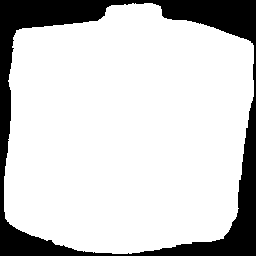
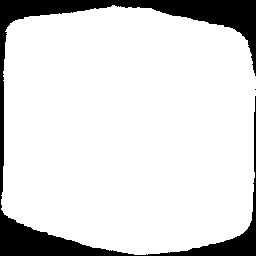

In [36]:
# Load and Process Image

# Image path
image_path = "Example images/Dog 2.jpeg"

# Prompt
prompt = ("Segment the image to identify peper, salt."
          "Return the result as a JSON list, where each entry includes:"
          "1) 'box_2d' — the 2D bounding box in [x_min, y_min, x_max, y_max] format,"
          "2) 'mask' — the segmentation mask represented as a list of polygon coordinates (x, y),"
          "3) 'label' — a descriptive text label of the object (e.g., 'cat'). "
          "Provide only valid JSON with no placeholder text or markup."
          "Do not include any placeholder like <start_of_mask>. Only provide numeric coordinates.")

# Load and resize the image
image = Image.open(image_path)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

# Retry loop for API call
while current_retry < max_retries:
    try:
        print(f"Attempt {current_retry + 1}/{max_retries} to call the API...")
        
        # Original API request
        response = client.models.generate_content(model=model_gemini_2_5,
                                               contents=[resized_image, prompt],
                                               config=types.GenerateContentConfig(
                                                   temperature=temperature,
                                                   safety_settings=safety_settings,
                                                   thinking_config=types.ThinkingConfig(thinking_budget=0)))

        print("Success!")
        break

    except genai_errors.ClientError as e:
        # Handle client errors (e.g., 429)
        current_retry += 1
        if current_retry >= max_retries:
            print(f"Error: Reached max retries ({max_retries}). Aborting.")
            print(f"Last error: {e}")
            break
        
        print(f"429 Error. Waiting {wait_time}s before retry...")
        time.sleep(wait_time)
        wait_time *= 2 

    except Exception as e:
        # Catch unexpected errors
        print(f"Unexpected error: {e}")
        break

# Check if response is valid
if response:
    print(response.text)
else:
    print("Failed to get a response after all retries.")

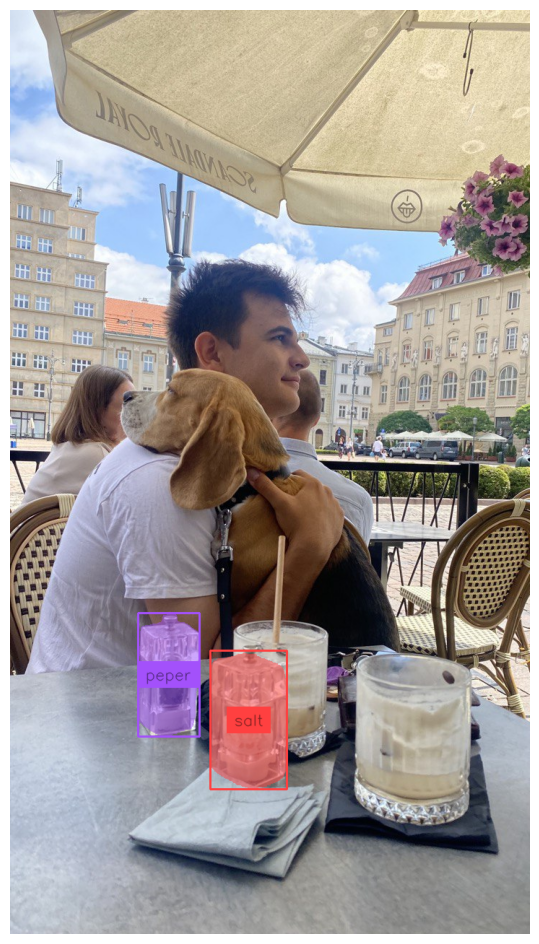

In [37]:
# Parse result and visualize

# Resolution of the image
resolution_wh = image.size

# Convert the model's output into Supervision Detections
detections = sv.Detections.from_vlm(vlm=sv.VLM.GOOGLE_GEMINI_2_5,
                                    result=response.text,
                                    resolution_wh=resolution_wh)

# Calculate optimal line thickness and text scale based on image resolution
thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

# Annotators for boxes, labels, and masks
box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(smart_position=True,
                                    text_color=sv.Color.BLACK,
                                    text_scale=text_scale,
                                    text_position=sv.Position.CENTER)
masks_annotator = sv.MaskAnnotator()

# Annotate the image with boxes and labels
annotated = image
for annotator in (box_annotator, label_annotator, masks_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)
    
# Display the annotated image
sv.plot_image(annotated)

### Cat.jpg

Attempt 4/10 to call the API...
Success!
```json
[
  {"box_2d": [386, 220, 706, 526], "mask": "", "label": "the cat"}
]
```

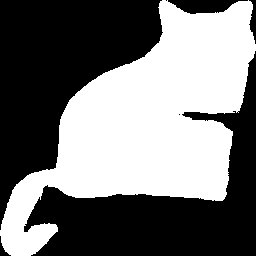

In [38]:
# Load and Process Image

# Image path
image_path = "Example images/Cat.jpg"

# Prompt
prompt = ("Segment the image to identify the cat."
          "Return the result as a JSON list, where each entry includes:"
          "1) 'box_2d' — the 2D bounding box in [x_min, y_min, x_max, y_max] format,"
          "2) 'mask' — the segmentation mask represented as a list of polygon coordinates (x, y),"
          "3) 'label' — a descriptive text label of the object (e.g., 'cat'). "
          "Provide only valid JSON with no placeholder text or markup."
          "Do not include any placeholder like <start_of_mask>. Only provide numeric coordinates.")

# Load and resize the image
image = Image.open(image_path)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

# Retry loop for API call
while current_retry < max_retries:
    try:
        print(f"Attempt {current_retry + 1}/{max_retries} to call the API...")
        
        # Original API request
        response = client.models.generate_content(model=model_gemini_2_5,
                                               contents=[resized_image, prompt],
                                               config=types.GenerateContentConfig(
                                                   temperature=temperature,
                                                   safety_settings=safety_settings,
                                                   thinking_config=types.ThinkingConfig(thinking_budget=0)))

        print("Success!")
        break

    except genai_errors.ClientError as e:
        # Handle client errors (e.g., 429)
        current_retry += 1
        if current_retry >= max_retries:
            print(f"Error: Reached max retries ({max_retries}). Aborting.")
            print(f"Last error: {e}")
            break
        
        print(f"429 Error. Waiting {wait_time}s before retry...")
        time.sleep(wait_time)
        wait_time *= 2 

    except Exception as e:
        # Catch unexpected errors
        print(f"Unexpected error: {e}")
        break

# Check if response is valid
if response:
    print(response.text)
else:
    print("Failed to get a response after all retries.")

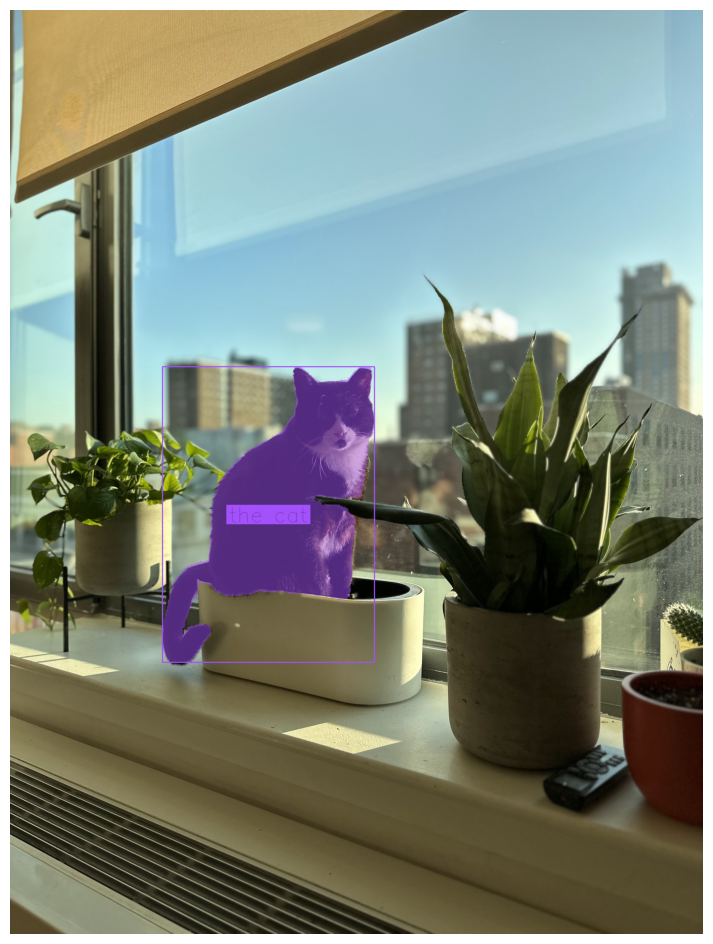

In [39]:
# Parse result and visualize

# Resolution of the image
resolution_wh = image.size

# Convert the model's output into Supervision Detections
detections = sv.Detections.from_vlm(vlm=sv.VLM.GOOGLE_GEMINI_2_5,
                                    result=response.text,
                                    resolution_wh=resolution_wh)

# Calculate optimal line thickness and text scale based on image resolution
thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

# Annotators for boxes, labels, and masks
box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(smart_position=True,
                                    text_color=sv.Color.BLACK,
                                    text_scale=text_scale,
                                    text_position=sv.Position.CENTER)
masks_annotator = sv.MaskAnnotator()

# Annotate the image with boxes and labels
annotated = image
for annotator in (box_annotator, label_annotator, masks_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)
    
# Display the annotated image
sv.plot_image(annotated)